# Basic Time Series Analysis

This notebook covers basic analysis of time series in pandas and statsmodels. We'll also use numpy and scipy for some computations, while using matplotlib and seaborn for doing some of the graphs.

For a better handling of the theory behind time series analysis consult a good book. Two authors with published works in the space are Rob Hyndman, John Gottman.

Key topics covered here are:

1. Reading and describing pandas datasets and time series
2. Date and time handling in pandas
3. Simple line plots and visualizations
4. Autocorrelation analysis
5. Correlograms for partial and full autocorrelation
6. Ljung Box test for autocorrelation
7. Seasonal decomposition analysis
8. Simple intro to AR modeling
9. ARMA, ARIMA, VAR and VARMA models - a basic intro

This isn't meant to be a theoretical treatment of the TSA ideas. This only demonstrates how to do TSA within Python's data science stack.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def gen_data(years, start_date):
    x1,x2,x3 = np.random.normal(10,1,years*365), np.random.normal(15,2,years*365), np.random.normal(12.2,3,years*365)
    index = pd.date_range(start=start_date, periods=years*365)
    index2 = np.arange(1,(years*365)+1,1)
    data = {"index":index, "x1":x1, "x2":x2, "x3":x3, "x4":x1+x2, "x5": (x2+np.sin(x1)+0.05*index2 + 3*np.sin(index2/30)), "x6": x3+2*x2, "x7": x3 + 10*np.sin(index2/30)}
    data = pd.DataFrame(data).set_index("index")
    return data

In [3]:
dataset = gen_data(10,"2005-01-01")

In [4]:
dataset.describe()

,x1,x2,x3,x4,x5,x6,x7
count,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000
mean,9.974194,14.958747,12.087142,24.932941,105.952172,42.004637,12.182447
std,1.015697,1.975892,3.011025,2.217678,52.734997,4.986075,7.666277
min,6.492815,8.041814,-0.432570,17.493779,11.231772,22.840030,-10.432472
25%,9.298239,13.658683,10.030528,23.468100,59.765803,38.622340,5.556908
50%,9.960767,14.937895,12.016394,24.916757,105.550600,41.987533,12.362938
75%,10.683757,16.288159,14.152667,26.422944,151.417191,45.296306,18.776468
max,13.130212,21.570221,22.537211,31.991555,202.694398,59.330525,31.572118


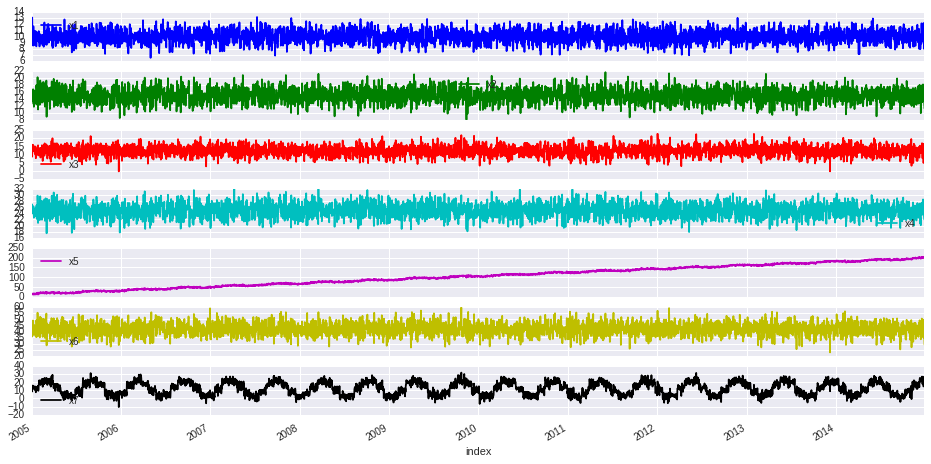

In [5]:
dataset.plot(subplots=True, figsize=(16,8))
plt.show()

## Autocorrelation analysis

Autocorrelation studies help us understand if observed values of a parameter are related to previous values of that parameter. This can be done in two ways:

* Computing the autocorrelation and partial autocorrelation function values for numerous lags (each lag here refers to one time stamp)
* Plotting ACF and PACF plots for these variables

Both of these activities can be done within the statsmodels package.

In [6]:
import statsmodels.tsa.api as sm

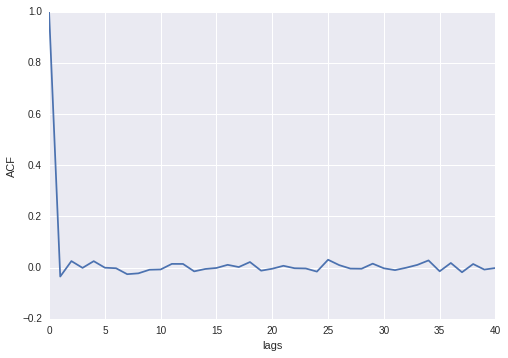

In [7]:
x1acf = sm.acf(dataset['x1'])
plt.plot(x1acf)
plt.xlabel("lags")
plt.ylabel("ACF")

Observe that the autocorrelation function for any lag greater than 0 is actually close to zero. This is an indication that the data we have here is random and doesn't have any specific pattern in it.

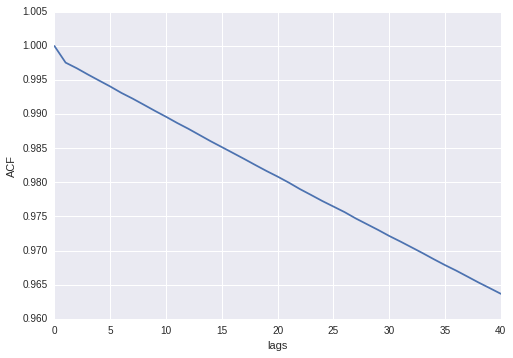

In [8]:
x5acf = sm.acf(dataset['x5'])
plt.plot(x5acf)
plt.xlabel("lags")
plt.ylabel("ACF")

In case of x5 and x7 below, there is a marked autocorrelation because there are non-zero values of ACF for subsequent lags up to and including 40 lags.

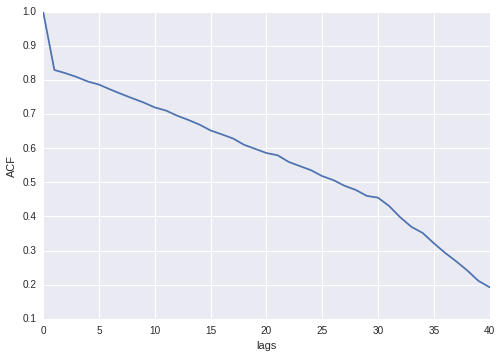

In [9]:
x7acf = sm.acf(dataset['x7'])
plt.plot(x7acf)
plt.xlabel("lags")
plt.ylabel("ACF")

Another way to do the same thing is by using TSA plots from statsmodels. The benefit of doing this is that we have a confidence band of ACF and PACF function values at each lag position, and this helps determine whether the ACF is significant or not.

In [10]:
from statsmodels.graphics import tsaplots

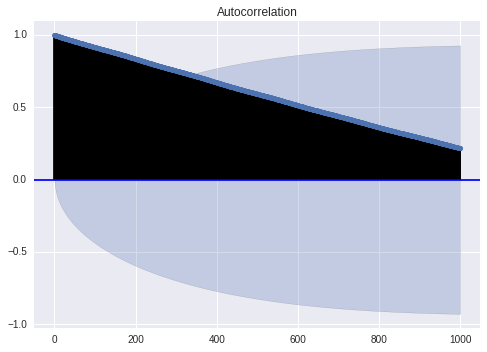

In [11]:
tsaplots.plot_acf(dataset['x5'], lags = 1000);

We can see from the autocorrelation function values at various lags that at around 300 lags, the autocorrelation function stops being significant. The shaded portion indicates the band of insignificant values, and anything beyond this represents a significant result.

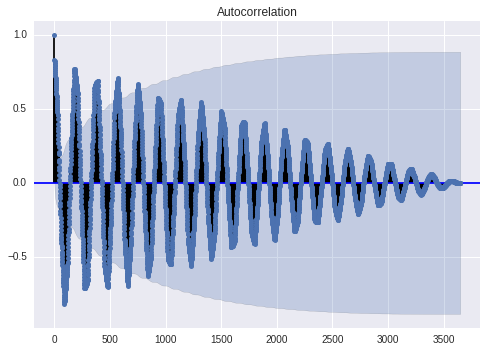

In [12]:
tsaplots.plot_acf(dataset['x7']);

In this ACF plot, we can see the impact of seasonality. The seasonality and lag impact taper off as we approach 700 lags or so.

Further notes on autocorrelation may be found here: http://robjhyndman.com/uwafiles/fpp-notes.pdf (Book by Rob J Hyndman, authority on time series analysis).

## Moving Average analysis

* This approach is useful when we're studying the bulk behaviour of what appears to be a chaotic data set.
* When we know autocorrelation of some kind exists, moving averages help us understand whether there is consistent and predictable change in the data over time.

Below, we construct a 30 day moving average of the parameter x1, and visualize it.

## Moving average plot with a 30 day window

In [13]:
x1ma = pd.rolling_mean(dataset['x1'], window = 30)

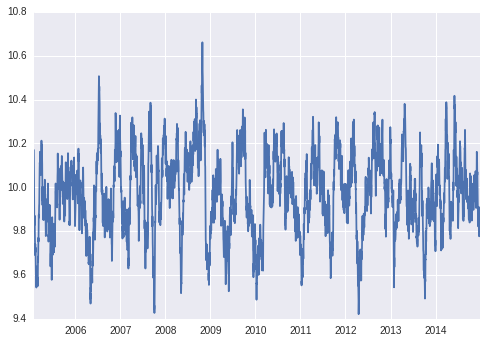

In [14]:
plt.plot(x1ma)

We can also plot directly from the x1ma object, since it is a pandas Series object. Figsize can be specified within the command itself, and indices are inherited from the parent data frame which was sliced to create the moving average variable.

Things to bear in mind:
* Moving average produces series which are prepended with NA values
* When plotting, these NA values are shown but are not visible clearly when we have a large sample with small moving average windows

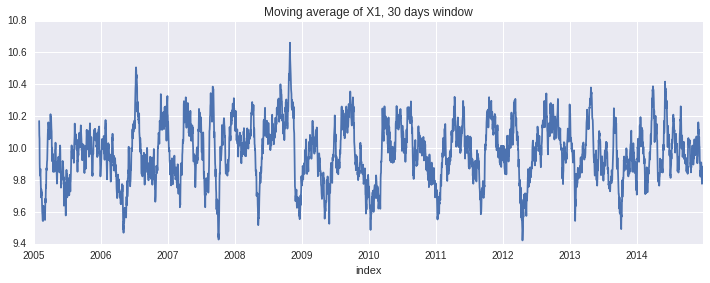

In [15]:
x1ma.plot(figsize=(12,4), title = "Moving average of X1, 30 days window")

## Moving average plot with a 365 day moving window

In [17]:
x1ma_yearly = pd.rolling_mean(dataset['x1'], window = 365)

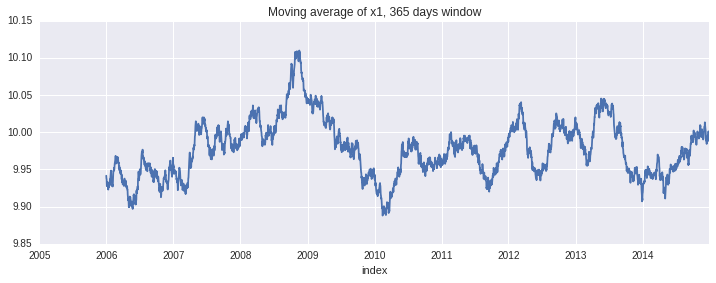

In [18]:
x1ma_yearly.plot(figsize=(12,4), title = "Moving average of x1, 365 days window")

Observe how in the above moving average plot the NAs appended to the start of the series show up as empty points on the graph. We can confirm that as below.

In the first 365 points of the x1ma_yearly series, there is only one point with a moving average, namely the last one. Therefore, you'll find that the last point in that slice of the series is represented below.

In [22]:
print "Number of time stamps with NA: ", len(x1ma_yearly[0:365]) - len(x1ma_yearly[0:365].dropna())

Number of time stamps with NA:  364


## Partial autocorrelation function plots

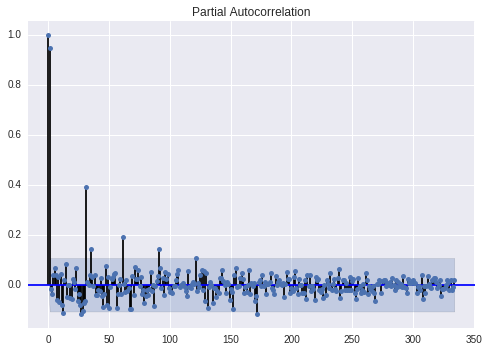

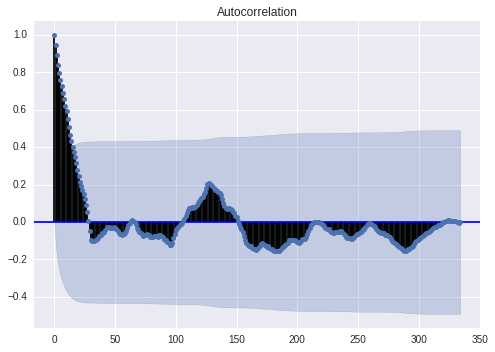

In [23]:
tsaplots.plot_pacf(x1ma[30:365]);
tsaplots.plot_acf(x1ma[30:365]);

The above plots show partial autocorrelation **correlogram** and a full autocorrelation **correlogram** for the same data.

The autocorrelation plots here show partial autocorrelation, that is, autocorrelation of the variable at each time stamp at t = $\tau$ with the variable at t = $\tau - k$ with all intermediate values removed. By comparison, autocorrelation function takes all lag values between $\tau$ and $\tau-k$ into account.

## Lag Plots

Lag plots are another way to understand autocorrelation in variables.

* If there is no structure in the data that's related to autocorrelation, the data looks completely random.
* If there is structure in the data, non-random patterns, such as ellipses, lines or circles can be observed.

In [24]:
from pandas.tools.plotting import lag_plot

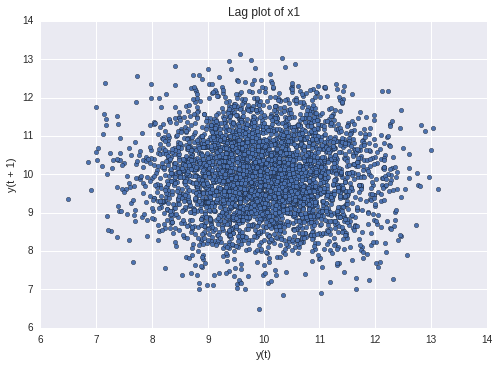

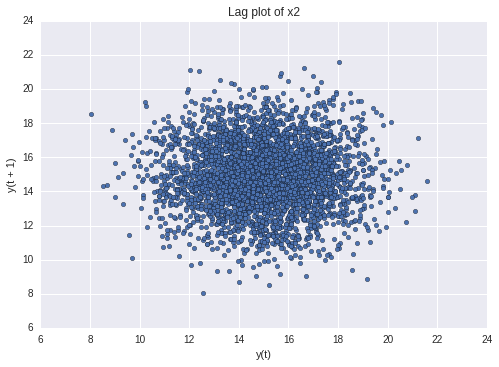

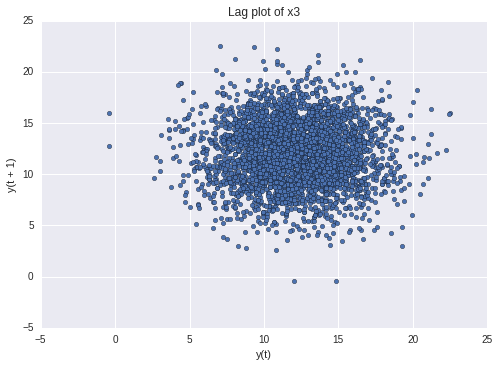

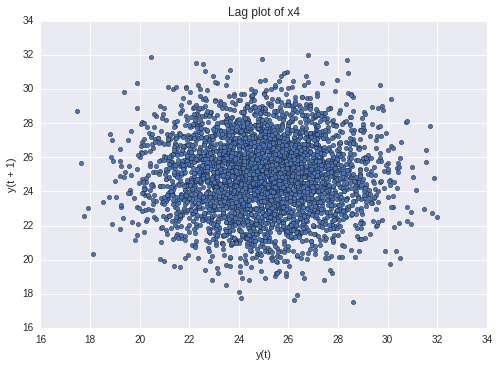

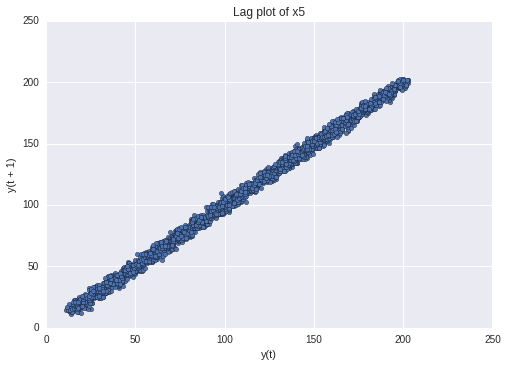

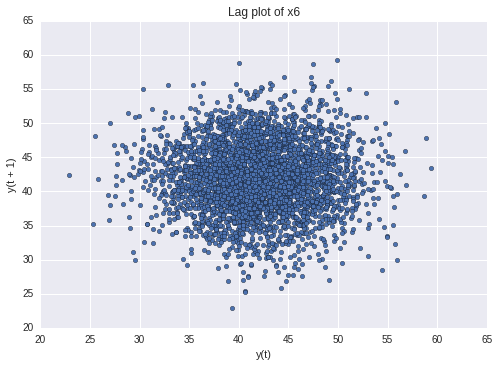

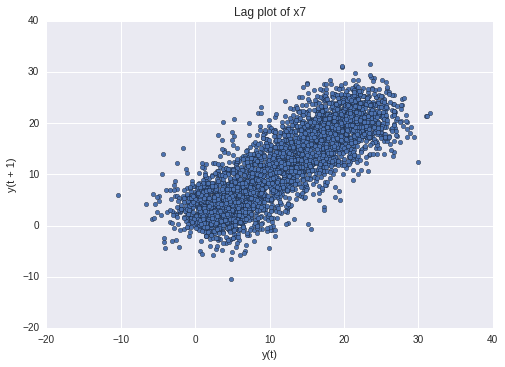

In [25]:
for column in dataset.columns:
    lag_plot(dataset[column])
    plt.title("Lag plot of "+column)
    plt.show()

## Cross Correlation Analysis

Cross correlation analysis helps us understand the relative relationship between two variables which are time series. The function implemented in statsmodels tsa is used for this.

In [26]:
from statsmodels.tsa.stattools import ccf

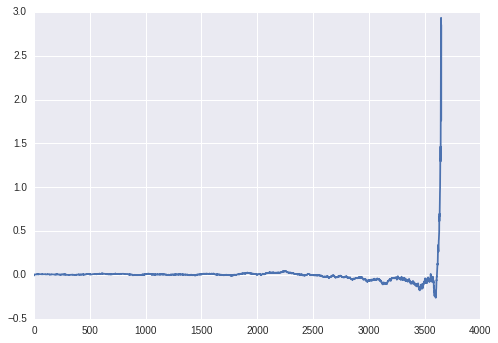

In [27]:
plt.plot(ccf(dataset['x5'], dataset['x1']))

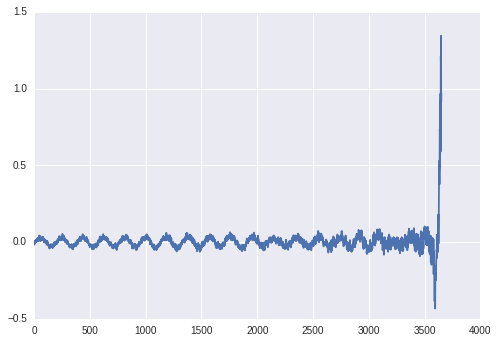

In [28]:
plt.plot(ccf(dataset['x7'], dataset['x1']))

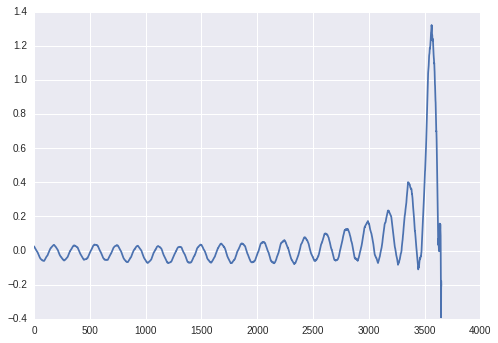

In [29]:
plt.plot(ccf(dataset['x5'], dataset['x7']))

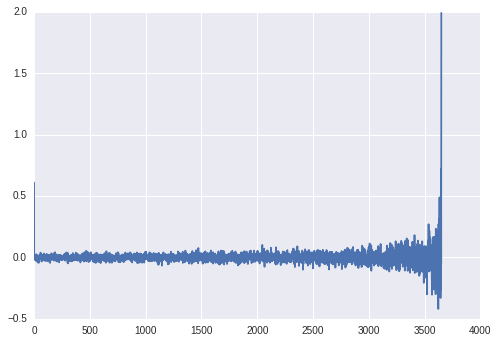

In [30]:
plt.plot(ccf(dataset['x3'], dataset['x6']))

## Cross Correlation and Autocorrelation relationship

Under certain conditions, the CCF of a variable with itself will (expectedly) be the same as the autocorrelation function for that variable.

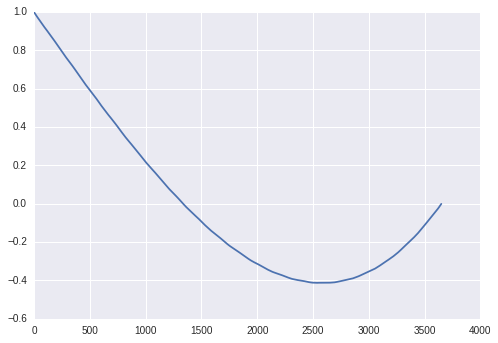

In [42]:
plt.plot(ccf(dataset['x5'], dataset['x5'], unbiased=False))


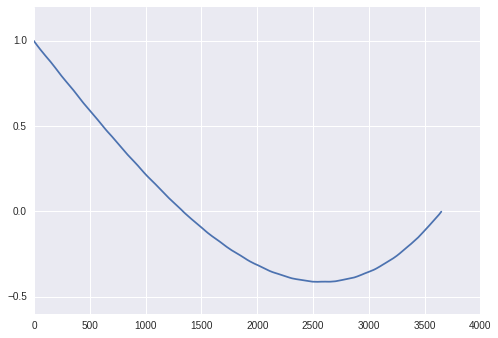

In [44]:
plt.plot(sm.acf(dataset['x5'], fft=True, nlags=4000))

## Decomposition Analysis

Decomposition analysis essentially allows us to separate out the components of each time series. Separating the components out helps us understand the impact of trends, seasonality and random noise on the time series data. It also allows us to make predictions on the series.

Within Python this is done with statsmodels.tsa's seasonal_decompose function.

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [126]:
dataset['x1'].index

DatetimeIndex(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04',
               '2005-01-05', '2005-01-06', '2005-01-07', '2005-01-08',
               '2005-01-09', '2005-01-10',
               ...
               '2014-12-20', '2014-12-21', '2014-12-22', '2014-12-23',
               '2014-12-24', '2014-12-25', '2014-12-26', '2014-12-27',
               '2014-12-28', '2014-12-29'],
              dtype='datetime64[ns]', name=u'index', length=3650, freq=None)

In [168]:
decomposed = seasonal_decompose(dataset['x5'].values, freq=365)

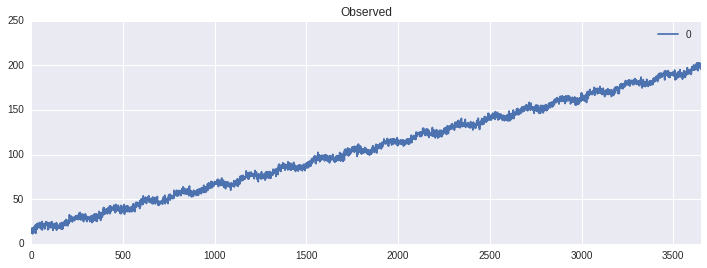

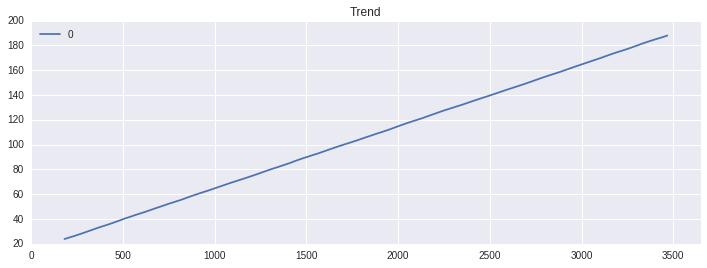

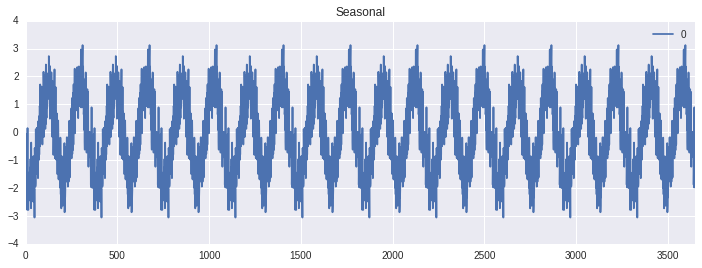

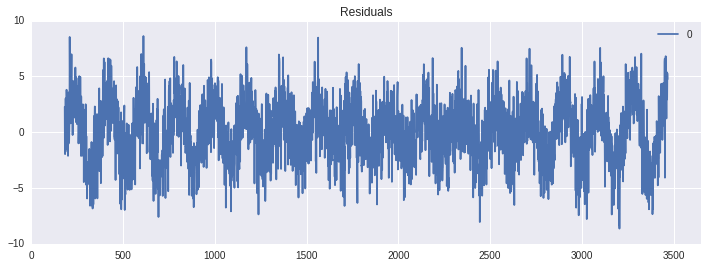

In [169]:
pd.DataFrame(decomposed.observed).plot(figsize=(12,4), title = "Observed")
pd.DataFrame(decomposed.trend).plot(figsize=(12,4), title = "Trend")
pd.DataFrame(decomposed.seasonal).plot(figsize=(12,4), title = "Seasonal")
pd.DataFrame(decomposed.resid).plot(figsize=(12,4), title = "Residuals")

We see above that the residuals aren't entirely random themselves. When residuals are random, that's an indication that we've got the best possible model. 

### Exercise:

Can you experiment with the data to find the right frequency and model type for decomposition, that produces a good result in terms of residuals, trends, seasonality?

## AR and ARIMA Forecasting Models

Autoregression can be used to build forecasting models that predict future values of a time series based on past values in the time series. Here's an example with the variable x1.

The statsmodels package (here imported with the alias "sm") has an autoregressive model under AR. This can be used to build a model and make predictions.

Mean of predictions:  9.91952662288 Standard error of predictions:  0.00144433678274


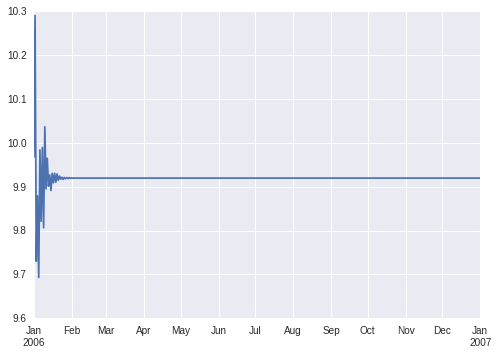

Mean of actuals:  9.95342337206 Standard error of actuals:  0.0536267678218


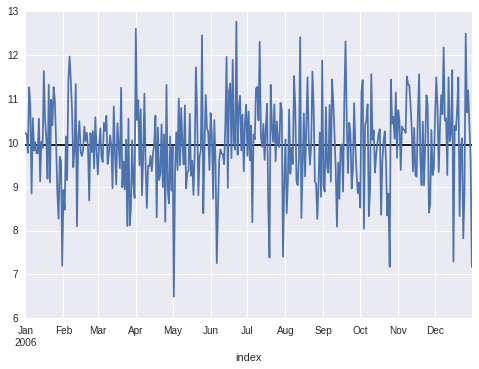

In [75]:
#Building the model and fitting it
ar_model = sm.AR(dataset['x1'][0:365])
ar_result = ar_model.fit(maxlag=10)

#Calculating the predictions for year 2 and plotting them
from scipy.stats import sem
predictions_year2 = ar_result.predict(365, 365*2)
predictions_year2.plot()
print "Mean of predictions: ", np.mean(predictions_year2.values), "Standard error of predictions: ", sem(predictions_year2.values)
plt.show()

#Plotting and describing the data in actuals
actuals = dataset['x1'][365:365*2]
actuals.plot()
plt.hlines(np.mean(actuals), xmin = min(actuals.index), xmax = max(actuals.index))
print "Mean of actuals: ", np.mean(actuals.values), "Standard error of actuals: ", sem(actuals.values)

Mean of predictions:  105.15995553 Standard error of predictions:  0.0466129283042


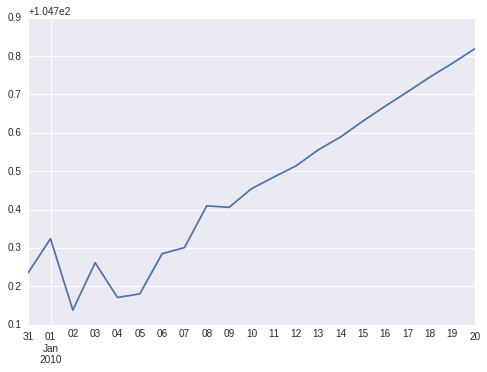

Mean of actuals:  103.752127121 Standard error of actuals:  0.394651202403


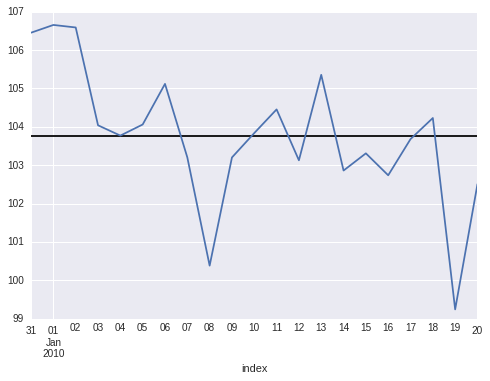

In [80]:
#Building the model and fitting it
ar_model = sm.AR(dataset['x5'][0:365*5])
ar_result = ar_model.fit(maxlag=10)

#Calculating the predictions for year 2 and plotting them
from scipy.stats import sem
predictions_year2 = ar_result.predict(365*5, 365*5+20)
predictions_year2.plot()
print "Mean of predictions: ", np.mean(predictions_year2.values), "Standard error of predictions: ", sem(predictions_year2.values)
plt.show()

#Plotting and describing the data in actuals
actuals = dataset['x5'][365*5:365*5+21]
actuals.plot()
plt.hlines(np.mean(actuals), xmin = min(actuals.index), xmax = max(actuals.index))
print "Mean of actuals: ", np.mean(actuals.values), "Standard error of actuals: ", sem(actuals.values)

Key things to observe:
* Dissimilarity in standard errors
* Similarity in mean values
* Inability to capture trends, seasonality, etc


Mean of predictions:  9.91952662288 Standard error of predictions:  0.00144433678274


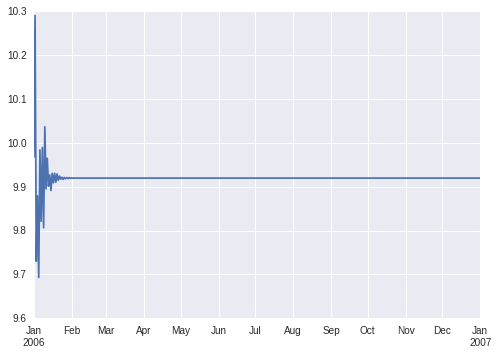

Mean of actuals:  9.95342337206 Standard error of actuals:  0.0536267678218


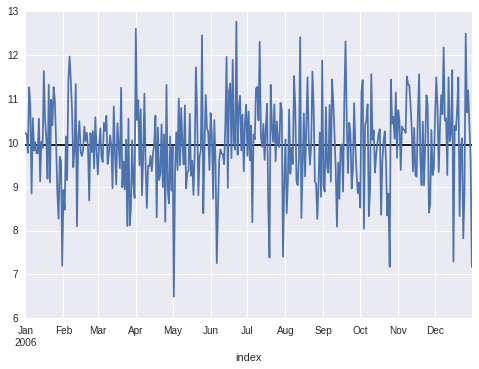

In [75]:
#Building the model and fitting it
ar_model = sm.AR(dataset['x1'][0:365])
ar_result = ar_model.fit(maxlag=10)

#Calculating the predictions for year 2 and plotting them
from scipy.stats import sem
predictions_year2 = ar_result.predict(365, 365*2)
predictions_year2.plot()
print "Mean of predictions: ", np.mean(predictions_year2.values), "Standard error of predictions: ", sem(predictions_year2.values)
plt.show()

#Plotting and describing the data in actuals
actuals = dataset['x1'][365:365*2]
actuals.plot()
plt.hlines(np.mean(actuals), xmin = min(actuals.index), xmax = max(actuals.index))
print "Mean of actuals: ", np.mean(actuals.values), "Standard error of actuals: ", sem(actuals.values)

## Ljung Box test for autocorrelation

Two key significance tests can be used for autocorrelation:

* Ljung-Box Q test
* Dickey Fuller test for unit root

We'll deal with the first here. 


$H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).

$H_a$: The data are not independently distributed; they exhibit serial correlation. 

Different variables exhibit different results (p-vals and Q stats) in this test.


       P value:   Q statistic: 
0   1.898081e-11      45.073171
1   1.586251e-10      45.128955
2   8.555150e-10      45.160169
3   3.682411e-09      45.160203
4   1.325962e-08      45.192299
5   4.285961e-08      45.192301
6   1.254785e-07      45.192579
7   3.331190e-07      45.228097
8   8.273716e-07      45.255840
9   1.952236e-06      45.259678
10  4.362385e-06      45.262617
11  9.241365e-06      45.275948
12  1.872426e-05      45.289376
13  3.641907e-05      45.303220
14  6.852968e-05      45.305056
15  1.245994e-04      45.305163
16  2.186158e-04      45.314133
17  3.731913e-04      45.314564
18  6.114699e-04      45.353353
19  9.843393e-04      45.365095
20  1.549939e-03      45.366654
21  2.380210e-03      45.371560
22  3.577498e-03      45.372074
23  5.260838e-03      45.373120
24  7.528464e-03      45.399044
25  1.034302e-02      45.509597
26  1.431599e-02      45.521647
27  1.951319e-02      45.523420
28  2.613937e-02      45.525920
29  3.418225e-02      45.563569
30  4.43

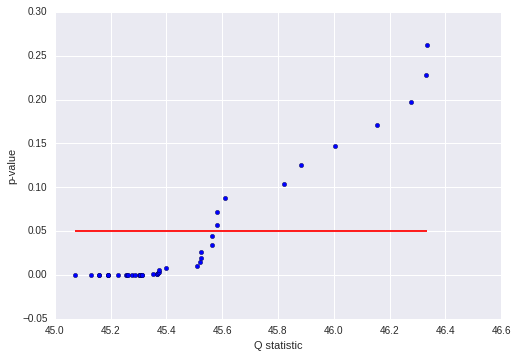

In [119]:
qstat, pval = sm.stattools.q_stat(sm.acf(dataset['x1']), 42)
print pd.DataFrame({"Q statistic: ": qstat, "P value: ": pval})
plt.scatter(qstat, pval)
plt.hlines(0.05, min(qstat), max(qstat), colors = "r")
plt.xlabel("Q statistic")
plt.ylabel("p-value")
plt.show()


## ARMA, ARIMA, VAR and VARMA models

By combining autoregression properties of the data and moving averages of the data, we can get ARIMA models, which are better at handling things like trends, seasonality and so on.

* ARMA = Autoregressive Moving Average
* ARIMA = Autoregressive Integrated Moving Average
* VAR = Vector Autoregression
* VARMA = Vector Autoregressive Moving Average

The first two of the above models are univariate cases, where we're evaluating one series and trying to predict values for future steps.

The next two are linear lag models of entire data sets, where different series are affecting other series of data. Each time step therefore represents some system state vector. The model performs autoregression on these vectors, to arrive at future values of these vectors.

For the sake of brevity, we'll handle ARMA, ARIMA, VAR and VARMA models in a future notebook.